# RNNLunchJ Better Version

### Reminders:

Read up on some of these:
- https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/
- https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html 
- https://github.com/keras-team/keras/issues/5714
- https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/



## Pre-Processing

### Download data

In [ ]:
! wget https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_training.csv
! mv MLchallenge2_training.csv train_data.csv

! wget https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_testing_inputs.csv
! mv MLchallenge2_testing_inputs.csv test_data.csv

--2020-12-03 18:43:17--  https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_training.csv
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285951722 (273M) [text/csv]
Saving to: ‘MLchallenge2_training.csv’

MLchallenge2_traini 100%[===================>] 272.70M  38.4MB/s    in 7.9s    

2020-12-03 18:43:25 (34.7 MB/s) - ‘MLchallenge2_training.csv’ saved [285951722/285951722]

--2020-12-03 18:43:25--  https://halldweb.jlab.org/talks/ML_lunch/Sep2019/MLchallenge2_testing_inputs.csv
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173137112 (165M) [text/csv]
Saving to: ‘MLchallenge2_testing_inputs.csv’

MLchallenge2_testin 100%[===================>] 165.12M  29.7MB/s    in

### Do Basic Imports

In [ ]:
import numpy as np
from tensorflow import keras
import pandas
from matplotlib import pyplot as plt
from math import isnan
from scipy.stats import norm

### Read training data

Read training data from .csv file and convert to a numpy array

In [ ]:
train_csv = pandas.read_csv("train_data.csv")
train_x = np.array(train_csv)

### Read testing data

A bit harder than the previous since data is incomplete pandas can't read it easily, plus the headers are missing aswell...

In [ ]:
the_max = 0
with open("test_data.csv","r") as mfile:
  lines = mfile.readlines()
  for l in lines:
    data = len(l.split(','))
    the_max = max(the_max,data)
column_names = [i for i in range(0, the_max)]

val_csv = pandas.read_csv("test_data.csv", header=None, names=column_names)
val_data = val_csv.values.tolist()

print(train_x.shape)
print(train_csv.keys()[:20])
print(val_csv.keys())
print(val_data[0])

(194601, 150)
Index(['x', 'y', 'z', 'px', 'py', 'pz', 'x1', 'y1', 'z1', 'px1', 'py1', 'pz1',
       'x2', 'y2', 'z2', 'px2', 'py2', 'pz2', 'x3', 'y3'],
      dtype='object')
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            129, 130, 131, 132, 133, 134, 135, 136, 137, 138],
           dtype='int64', length=139)
[4.24695, -4.43401, 65.0, 0.10800799999999999, 0.139515, 1.9407, 11.63, 2.435, 176.94400000000002, 0.146779, 0.0969276, 1.92955, 11.7922, 2.54127, 179.06900000000002, 0.147668, 0.0961406, 1.9295099999999998, 11.9553, 2.64665, 181.195, 0.148254, 0.0952322, 1.9294900000000001, 12.1188, 2.7509099999999997, 183.32, 0.148627, 0.0942079, 1.9294900000000001, 12.2826, 2.85433, 185.445, 0.149117, 0.0933778, 1.9294799999999999, 12.4474, 2.95667, 187.571, 0.149841, 0.092512, 1.92945, 16.3289, 4.9551099999999995, 235.514, 0.162475, 0.0675623, 1.9293200000000001, 16.5082, 5.02894, 237.639, 0.162772, 0.0667449, 1.9293099999999999, 16.6876, 5.10192, 239.

### Read new testing data

In [ ]:
test_csv = pandas.read_csv("drive/MyDrive/tracking_testData.csv")
test_data = np.array(test_csv)

### Parse Data


In [ ]:
def parser(data, randomInput):
  data = data
  step = 6
  inputs = 6
  outputs = 6
  if randomInput:
    inputLayers = 23
  else:
    inputLayers = 23

  batches_x = []
  batches_y = []

  for i in range(len(data)):
    index = 0 
    one_set_x = []
    one_set_y = []
    while index+inputs+outputs < len(data[i]):
      mid = index + inputs
      one_set_x.append(data[i][index:mid]) # + data[i,mid+3] # later fix to get z value

      # TimeSeries needs a 3D output too; so when using Time you need .append
      # one_set_y = data[i][mid:mid+outputs]
      one_set_y.append(data[i][mid:mid+outputs])

      flag = False
      for x in one_set_x[-1]:
        if isnan(x):
          flag = True
      # If using Time use the [-1]
      # for y in one_set_y:
      for y in one_set_y[-1]:
        if isnan(y):
          flag = True
      if flag:
        break
      if len(one_set_x) == inputLayers:
        batches_x.append(one_set_x)
        batches_y.append(one_set_y)
        one_set_x = one_set_x[1:]
        # if using Time uncommend
        one_set_y = one_set_y[1:]
      index += step

  batches_x = np.array(batches_x)
  batches_y = np.array(batches_y)
  print("x",batches_x.shape)
  print("y",batches_y.shape)
  return batches_x,batches_y



def test_parser(data):
  step = 6
  inputs = 6
  outputs = 6
  # inputLayers = 1

  batches_x = []
  batches_y = []

  for i in range(len(data)):
    index = 0
    one_set_x = []
    one_set_y = []

    time_steps_x = []
    time_steps_y = []
    while index+inputs+outputs < len(data[i]):
      mid = index + inputs
      # one_set_x.append(data[i][index:mid]) # + data[i,mid+3] # later fix to get z value

      # # TimeSeries needs a 3D output too; so when using Time you need .append
      # # one_set_y = data[i][mid:mid+outputs]
      # one_set_y.append(data[i][mid:mid+outputs])

      one_set_x = data[i][index:mid]
      one_set_y = data[i][mid:mid+outputs]

      # flag = False
      # for x in one_set_x[-1]:
      #   if isnan(x):
      #     flag = True
      # # If using Time use the [-1]
      # # for y in one_set_y:
      # for y in one_set_y[-1]:
      #   if isnan(y):
      #     flag = True
      # if flag:
      #   break


      # if len(one_set_x) == inputLayers:
      time_steps_x.append(one_set_x)
      time_steps_y.append(one_set_y)


        # # batches_x.append(one_set_x)
        # # batches_y.append(one_set_y)
        # one_set_x = one_set_x[1:]
        # # if using Time uncommend
        # one_set_y = one_set_y[1:]

      index += step
    batches_x.append(time_steps_x)
    batches_y.append(time_steps_y)

  batches_x = np.array(batches_x)
  batches_y = np.array(batches_y)
  print("x",batches_x.shape)
  print("y",batches_y.shape)
  return batches_x,batches_y

In [ ]:
# x_train,y_train = parser(train_x[:170000], True)
x_train,y_train = parser(train_x[:169984], True)
print("val")
# val_x, val_y = parser(val_data, False)
val_x, val_y = parser(train_x[170000:180000], False)
test_data_x, test_data_y = test_parser(test_data)
# print("train0:",x_train[0].shape)
# print("val")
# val_x, val_y = parser(val_data, False)
# for set_ in range(len(val_x)):
#   val_x[set_] = np.array(val_x[set_])
# for set_ in range(len(val_y)):
#   val_y[set_] = np.array(val_y[set_])

# val_x = np.array(val_x)
max = x_train.max()
min = x_train.min()
x_train = (x_train - min) / (max - min)
val_x = (val_x - min) / (max - min)
test_data_x = (test_data_x - min) / (max - min)

x (169984, 23, 6)
y (169984, 23, 6)
val
x (10000, 23, 6)
y (10000, 23, 6)
x (14601, 23, 6)
y (14601, 23, 6)


## Model

### Different models

RNN
- Input data and returns the next in line
- notice the return_sequences=False in the last LSTM
- will only return one value


RNNTime
- Maybe I should stop naming them all RNN...
- Returns with TimeSteps
- As I understand it so far:
  - Feeds first data given, predicts next
  - Feeds next data while remembering the previous data point and predicting the next relative to the one just fed.
  - Here, just look at [this](https://i.stack.imgur.com/13opm.jpg) image and [this](https://github.com/MohammadFneish7/Keras_LSTM_Diagram) diagram
- In the end returns a shape (timesteps,6)

RNNTimeStateful
- The name is getting long...
- Stateful only resets the RNN memory when manually reset...
- Not the best with the current .fit() code

split_it
- Splits data into each variable to few seperately
- Most of the rest of the code will not work!!

-------

~~OLD_RNN~~
- ~~most basic RNN model with one LSTM(10) layer~~

~~OLD_RNNOther~~
- ~~GRU (Gated Recurrent Unit) layer that supposedly works well with GPU~~
- ~~LSTM works with GPU under specific variables.~~
- ~~SimpleRNN ?~~

~~OLD_DenseTest~~
- ~~I was just testing how well this would work with just Dense Layers~~
- ~~Spoiler, it doesn't, (I'm kidding, I haven't actually tested it yet...)~~

ANYTHING ~~CROSSED OUT~~ IS UNDER DEPRICATED AT THE BOTTOM


In [ ]:
# Removed input_shape=inp because I remember it was not needed, but I might be wrong...
# x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', 
#                       input_shape=inp, stateful=False, return_sequences=True)(x)
# add input parameter of inp back in if it fails!

def RNN(x):
  x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', return_sequences=True)(x)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm2', return_sequences=True)(x)
  x = keras.layers.LSTM(32,activation="tanh", name='lstm3', return_sequences=False)(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  x = keras.layers.Dense(6, activation='linear')(x)
  return x
def RNNTime(x):
  x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', batch_input_shape=(1,None,6), stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm2', stateful=False, return_sequences=True)(x)
  x = keras.layers.LSTM(32,activation="tanh", name='lstm3', stateful=False, return_sequences=True)(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'))(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(6, activation='linear'))(x)
  return x
def RNNTimeStateful(x):
  # https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
  x = keras.layers.LSTM(128,activation="tanh", name='input_lstm1', 
                        batch_input_shape=(128,None,6), stateful=True, return_sequences=True)(x)
  x = keras.layers.LSTM(64,activation="tanh", name='lstm2', stateful=True, return_sequences=True)(x)
  x = keras.layers.LSTM(32,activation="tanh", name='lstm3', stateful=True, return_sequences=True)(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(32, activation='relu'))(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(6, activation='linear'))(x)
  return x


def split_it(inp):
  x = keras.layers.Dense(1, activation="linear", name="x_out")(inp)
  y = keras.layers.Dense(1, activation="linear", name="y_out")(inp)
  z = keras.layers.Dense(1, activation="linear", name="z_out")(inp)
  px = keras.layers.Dense(1, activation="linear", name="px_out")(inp)
  py = keras.layers.Dense(1, activation="linear", name="py_out")(inp)
  pz = keras.layers.Dense(1, activation="linear", name="pz_out")(inp)
  return [x,y,z,px,py,pz]



### Build model

Choose Input type, currently trying to convert 128 batch size for training to 1 for when I use test data

Set a constant seed to test if model is just bad or bad random values?

~~Categorizing the values of the outputs, does not work with the rest of the code!~~
- moved to depricated at the very bottom of notebook

Choose model.

In [ ]:
inputs = keras.layers.Input((None,6),batch_size=1)
# inputs = keras.layers.Input((None,6),batch_size=128)
# inputs = keras.layers.Input((None,6))
print("train shape of one batch:", x_train.shape[1:])

# --==Set seed to get identical results==-- begin
# from tensorflow.random import set_seed
# np.random.seed(1)
# set_seed(2)
# --==Set seed to get identical results==-- end

# -=Depricated=-
# x = RNN((None,7),inputs)      # OLD
# x = RNNOther((None,6),inputs) # OLD
# x = DenseTest(inputs)         # OLD


# x = RNN(inputs)
x = RNNTime(inputs)
# x = RNNTimeStateful(inputs)
model = keras.Model(inputs=inputs, outputs=x, name="RNNModel")

train shape of one batch: (23, 6)


### Compile Model

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.8)

optimizer = keras.optimizers.Adam(learning_rate=0.001)


#--==Set Weights==--
# loss_weights = [1/(0.20374708177972334**2),
#                 1/(0.2713061404371925**2),
#                 1/(0.10484799308587896**2),
#                 1/(0.10405550103569539**2),
#                 1/(0.10972255464315309**2),
#                 1/(0.8609325026290453**2)]
# loss_weights = np.array(loss_weights)/sum(loss_weights)
# model.compile(optimizer=optimizer, loss="mse", loss_weights=loss_weights, metrics=["mae"])


model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

model.summary()

Model: "RNNModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(1, None, 6)]            0         
_________________________________________________________________
input_lstm1 (LSTM)           (1, None, 128)            69120     
_________________________________________________________________
lstm2 (LSTM)                 (1, None, 64)             49408     
_________________________________________________________________
lstm3 (LSTM)                 (1, None, 32)             12416     
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 32)          1056      
_________________________________________________________________
time_distributed_15 (TimeDis (None, None, 6)           198       
Total params: 132,198
Trainable params: 132,198
Non-trainable params: 0
____________________________________________________

## Fit model

Gets stuck on loss=105 for ~10 epochs for some reason...


In [ ]:
# Current Best
es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=5, mode='min', verbose=1, restore_best_weights=True)
H = model.fit(x=x_train, y=y_train, batch_size=128, epochs=200, shuffle=True, verbose=1, callbacks=[es])

# Overfit
# es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=100, mode='min', verbose=1, restore_best_weights=True)
# H = model.fit(x=x_train[:10], y=y_train[:10], batch_size=1, epochs=200, verbose=1, shuffle=True, callbacks=[es])


### Save Model

In [ ]:
model.save('RNNModel.h5', save_format="h5")

## Load Model

In [ ]:
# model = keras.models.load_model('RNNModel.h5')
model = keras.models.load_model('drive/MyDrive/RNNModel.h5')

## Using new test

### Making a new model
Making a new model with batch_size=1

Then loading old weights into the newly created model.

In [ ]:
inputs = keras.layers.Input((None,6), batch_size=1)
x = RNNTimeStateful(inputs)
old_weights = model.get_weights()
model = keras.Model(inputs=inputs, outputs=x, name="RNNModel")
model.set_weights(old_weights)

### Testing new model

In [ ]:
# reset states of the model
# https://stackoverflow.com/questions/43882796/when-does-keras-reset-an-lstm-state
# model.reset_states()

# model.layers[0].batch_size = 1
# model.layers[0].batch_shape = 1
model.layers[1].stateful = True
model.layers[2].stateful = True
model.layers[3].stateful = True

# model.layers[1].stateful = False
# model.layers[2].stateful = False
# model.layers[3].stateful = False

# print(test_data.shape)
# print(test_data[0])



# print(test_data_x.shape)
# print(test_data_x[2])
np.set_printoptions(suppress=True)


def missingTracks(test_data, final_true):
  for index, t in enumerate(test_data):
    if index == 0:
      continue

    goodValues = []
    for timestep in t:
      if isnan(timestep[0]):
        # print("triggered: ",timestep)
        experiment = np.array(goodValues)
        experiment = np.expand_dims(experiment,0)
        # print("exp shape: ",experiment.shape)
        # print("exp: ",experiment)

        # --==previous version==--
        # for i in range(len(goodValues)):
        #   goodValues[i] = np.expand_dims(goodValues[i],0)
        #   goodValues[i] = np.expand_dims(goodValues[i],0)
        # print("size goodVal: ",len(goodValues), goodValues[0].shape)
        # print("data in:",goodValues)
        # pred = model.predict(goodValues)[-1]

        # pred = model.predict(experiment, batch_size=1)[0][-1]
        pred = model.predict(experiment)[0][-1]
        goodValues = [pred]
      else:
        goodValues.append(timestep)
    experiment = np.array(goodValues)
    experiment = np.expand_dims(experiment,0)
    # print("final: exp shape: ",experiment.shape)
    # print("final: exp: ",experiment)
    # model.predict(goodValues)
    ans = model.predict(experiment)[0][-1]
    if isnan(final_true[index][0]):
      ans = np.around(ans,4)
      print("t:",index,ans)
    else:
      diff = final_true[index] - ans
      diff = np.around(diff,4)
      ans = np.around(ans,4)
      print("t:",index,ans)
      print("diff:",index,diff)
    print("================")

    model.reset_states()

missingTracks(test_data_x,test_data_y[:,-1,:])


AttributeError: ignored

## Graphs

### Graph loss and mae

In [ ]:
print(H.history.keys())
print("loss: ", H.history["loss"])
print("mae: ", H.history["mae"])
print("val_loss: ", H.history["val_loss"])
print("val_mae: ", H.history["val_mae"])

lim = 2

try:
  print(H.history["x_out_loss"])
  fig, ax = plt.subplots(1,2,figsize=(10,5))

  # ax[0].plot(H.history["loss"])
  ax[0].plot(H.history["x_out_loss"][lim:])
  ax[0].plot(H.history["y_out_loss"][lim:])
  ax[0].plot(H.history["z_out_loss"][lim:])
  ax[0].plot(H.history["px_out_loss"][lim:])
  ax[0].plot(H.history["py_out_loss"][lim:])
  ax[0].plot(H.history["pz_out_loss"][lim:])
  ax[0].set_title("epoch vs loss")

  ax[1].plot(H.history["x_out_mae"][lim:])
  ax[1].plot(H.history["y_out_mae"][lim:])
  ax[1].plot(H.history["z_out_mae"][lim:])
  ax[1].plot(H.history["px_out_mae"][lim:])
  ax[1].plot(H.history["py_out_mae"][lim:])
  ax[1].plot(H.history["pz_out_mae"][lim:])
  ax[1].set_title("epoch vs mae")
  
except KeyError:
    fig, ax = plt.subplots(2,1,figsize=(5,10))
    fig.subplots_adjust(hspace=0.35)

    ax[0].plot(H.history["loss"][lim:])
    ax[0].plot(H.history["val_loss"][lim:])
    ax[0].set_title("loss vs epoch", fontsize=20)
    ax[0].set_xlabel("epoch", fontsize=15)
    ax[0].set_ylabel("loss", fontsize=15)
    ax[0].legend(["train","val"])
    ax[0].grid(True)


    ax[1].plot(H.history["mae"][lim:])
    ax[1].plot(H.history["val_mae"][lim:])
    ax[1].set_title("mae vs epoch", fontsize=20)
    ax[1].set_xlabel("epoch", fontsize=15)
    ax[1].set_ylabel("mae", fontsize=15)
    ax[1].legend(["train","val"])
    ax[1].grid(True)


### Graph


In [ ]:
def doPlots(true_y,pred,diff):
  fig, axs = plt.subplots(4,6,figsize=(30,20))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)

  for i in range(6):
    (mu, sigma) = norm.fit(diff[:,i])
    print("data" , i ," |: mu: ", mu, "sigma: " , sigma)
    _, bins, _ = axs[0,i].hist(diff[:,i], 20, density=True)
    y = norm.pdf(bins, mu, sigma)
    l = axs[0,i].plot(bins, y, 'r--', linewidth=2)

  # axs[0,0].set_xlim([-10,10])

  axs[0,0].set_title('x diff')
  axs[0,0].set_ylabel('freq')
  axs[0,0].set_xlabel('x diff')

  axs[0,1].set_title('y diff')
  axs[0,1].set_ylabel('freq')
  axs[0,1].set_xlabel('y diff')

  axs[0,2].set_title('z diff')
  axs[0,2].set_ylabel('freq')
  axs[0,2].set_xlabel('z diff')

  axs[0,3].set_title('px diff')
  axs[0,3].set_ylabel('freq')
  axs[0,3].set_xlabel('px diff')

  axs[0,4].set_title('py diff')
  axs[0,4].set_ylabel('freq')
  axs[0,4].set_xlabel('py diff')

  axs[0,5].set_title('pz diff')
  axs[0,5].set_ylabel('freq')
  axs[0,5].set_xlabel('pz diff')

  #--------------------------------------
  # PREDICTED VS TRUE
  #--------------------------------------
    
  for i in range(6):
    axs[1,i].scatter(true_y[:,i],pred[:,i])
    axs[1,i].grid(True)

    # xl, xr = axs[1,i].get_xlim()
    # yl, yr = axs[1,i].get_ylim()
    # mmin = min(xr,yr)
    # mmax = max(xl,yl)
    # axs[1,i].plot([mmax,mmin],[mmax,mmin], color='b')

  axs[1,0].set_title('X (predicted vs true)')
  axs[1,0].set_ylabel('pred x')
  axs[1,0].set_xlabel('true x')
  axs[1,0].set_xlim([-40,40])
  axs[1,0].set_ylim([-40,40])
  axs[1,0].plot([-40,40],[-40,40], color='b')

  axs[1,1].set_title('Y (predicted vs true)')
  axs[1,1].set_ylabel('pred y')
  axs[1,1].set_xlabel('true y')
  axs[1,1].set_xlim([-40,40])
  axs[1,1].set_ylim([-40,40])
  axs[1,1].plot([-40,40],[-40,40], color='b')

  axs[1,2].set_title('Z (predicted vs true)')
  axs[1,2].set_ylabel('pred z')
  axs[1,2].set_xlabel('true z')
  axs[1,2].set_xlim([150,350])
  axs[1,2].set_ylim([150,350])
  axs[1,2].plot([150,350],[150,350], color='b')

  axs[1,3].set_title('PX (predicted vs true)')
  axs[1,3].set_ylabel('pred px')
  axs[1,3].set_xlabel('true px')
  axs[1,3].set_xlim([-0.2,0.2])
  axs[1,3].set_ylim([-0.2,0.2])
  axs[1,3].plot([-0.2,0.2],[-0.2,0.2], color='b')

  axs[1,4].set_title('PY (predicted vs true)')
  axs[1,4].set_ylabel('pred py')
  axs[1,4].set_xlabel('true py')
  axs[1,4].set_xlim([-0.2,0.2])
  axs[1,4].set_ylim([-0.2,0.2])
  axs[1,4].plot([-0.2,0.2],[-0.2,0.2], color='b')

  axs[1,5].set_title('PZ (predicted vs true)')
  axs[1,5].set_ylabel('pred pz')
  axs[1,5].set_xlabel('true pz')
  axs[1,5].set_xlim([0.5,3.5])
  axs[1,5].set_ylim([0.5,3.5])
  axs[1,5].plot([0.5,3.5],[0.5,3.5], color='b')

  #--------------------------------------
  # DIFFERENCE VS TRUE
  #--------------------------------------

  for i in range(6):
    axs[2,i].scatter(true_y[:,i],diff[:,i])
    l, r = axs[2,i].get_xlim()
    axs[2,i].hlines(0, l, r)
    axs[2,i].grid(True)

  axs[2,0].set_title('X (difference vs true)')
  axs[2,0].set_ylabel('diff x')
  axs[2,0].set_xlabel('true x')

  axs[2,1].set_title('Y (difference vs true)')
  axs[2,1].set_ylabel('diff y')
  axs[2,1].set_xlabel('true y')

  axs[2,2].set_title('Z (difference vs true)')
  axs[2,2].set_ylabel('diff z')
  axs[2,2].set_xlabel('true z')

  axs[2,3].set_title('PX (difference vs true)')
  axs[2,3].set_ylabel('diff px')
  axs[2,3].set_xlabel('true px')

  axs[2,4].set_title('PY (difference vs true)')
  axs[2,4].set_ylabel('diff py')
  axs[2,4].set_xlabel('true py')

  axs[2,5].set_title('PZ (difference vs true)')
  axs[2,5].set_ylabel('diff pz')
  axs[2,5].set_xlabel('true pz')

  #--------------------------------------
  # DIFFERENCE VS TRUE 2D HIST
  #--------------------------------------

  for i in range(6):
    axs[3,i].hist2d(true_y[:,i],diff[:,i],bins=20)


  axs[3,0].set_title('X (difference vs true)')
  axs[3,0].set_ylabel('diff x')
  axs[3,0].set_xlabel('true x')

  axs[3,1].set_title('Y (difference vs true)')
  axs[3,1].set_ylabel('diff y')
  axs[3,1].set_xlabel('true y')

  axs[3,2].set_title('Z (difference vs true)')
  axs[3,2].set_ylabel('diff z')
  axs[3,2].set_xlabel('true z')

  axs[3,3].set_title('PX (difference vs true)')
  axs[3,3].set_ylabel('diff px')
  axs[3,3].set_xlabel('true px')

  axs[3,4].set_title('PY (difference vs true)')
  axs[3,4].set_ylabel('diff py')
  axs[3,4].set_xlabel('true py')

  axs[3,5].set_title('PZ (difference vs true)')
  axs[3,5].set_ylabel('diff pz')
  axs[3,5].set_xlabel('true pz')

  fig.show()

### Actual Graphs

finished pred_
true:  (1000, 6)
pred:  (1000, 6)
diff:  (1000, 6)
data 0  |: mu:  0.4118998534881334 sigma:  0.17494296631392484
data 1  |: mu:  0.10830879854892987 sigma:  0.6854748521451126
data 2  |: mu:  -0.015353900756822782 sigma:  1.1135536168895404
data 3  |: mu:  -0.0062349142540888336 sigma:  0.11355013144734263
data 4  |: mu:  0.04519413846743401 sigma:  0.11902357303232428
data 5  |: mu:  -0.287769653793129 sigma:  0.17380802043597926


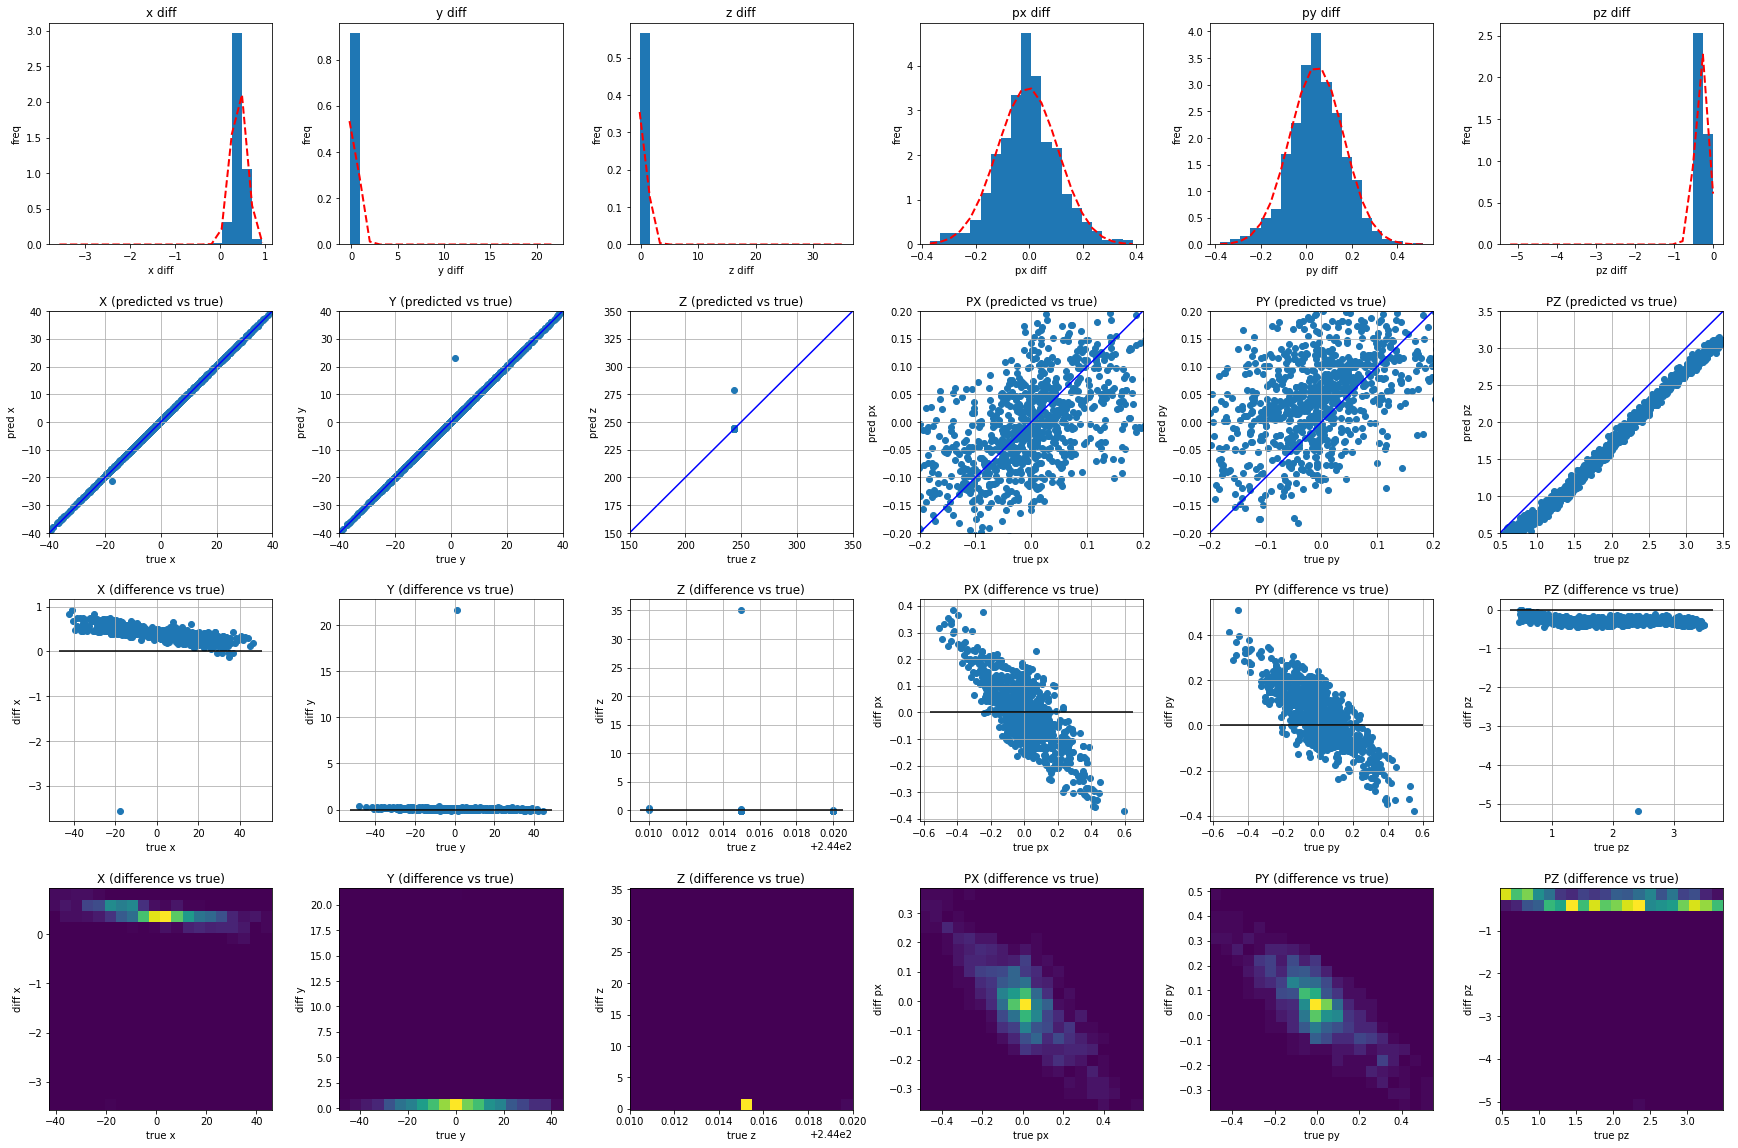

In [ ]:
numOfSets = 1000

usingTimeDistributed = True

if usingTimeDistributed:
  test_x = x_train[:numOfSets]
  true_y_ = y_train[:numOfSets]

  # pred_ = model.predict(np.expand_dims(test_x[0],0),batch_size=1)
  pred_ = np.empty((1,23,6))
  for index,t in enumerate(test_x):
    # if index == 0:
    #   continue
    t = np.expand_dims(t,0)
    # pred_ = np.append(pred_,model.predict(t,batch_size=1))
    pred_ = np.vstack((pred_,model.predict(t,batch_size=1)))
    # pred_.append(model.predict(t,bat/h_size=1))
    model.reset_states();
  # pred_ = np.array(pred_)
  print("finished pred_")

  pred_ = pred_[1:]

  diff_ = pred_ - true_y_

  true_y = []
  pred = []
  diff = []

  # for a in range(numOfSets):
  #   for b in range(7):
  #     true_y.append(true_y_[a,b])
  #     pred.append(pred_[a,b])
  #     diff.append(diff_[a,b])

  index = 10
  true_y = true_y_[:,index]
  pred = pred_[:,index]
  diff = diff_[:,index]

  true_y = np.array(true_y)
  pred = np.array(pred)
  diff = np.array(diff)
else:
  test_x = val_x[:numOfSets]
  true_y = val_y[:numOfSets]
  pred = model.predict(test_x)
  diff = pred - true_y

print("true: ",true_y.shape)
print("pred: ",pred.shape)
print("diff: ",diff.shape)


doPlots(true_y,pred,diff)

In [ ]:
index = 0
doPlots(np.array(true_y_[:,index]),np.array(pred_[:,index]),np.array(diff_[:,index]))

In [ ]:
index = val_y.shape[1]-1
doPlots(np.array(true_y_[:,index,:]),np.array(pred_[:,index,:]),np.array(diff_[:,index,:]))

In [ ]:
index = 1
doPlots(np.array(true_y_[:,index]),np.array(pred_[:,index]),np.array(diff_[:,index]))

In [ ]:
index = 2
doPlots(np.array(true_y_[:,index]),np.array(pred_[:,index]),np.array(diff_[:,index]))

In [ ]:
index = 3
doPlots(np.array(true_y_[:,index]),np.array(pred_[:,index]),np.array(diff_[:,index]))

## Depricated

Most likey not needed, but safe keeping

In [ ]:
def RNN(inp,x):
  x = keras.layers.LSTM(10,activation="relu", input_shape=inp, return_sequences=True)(x)
  x = keras.layers.TimeDistributed(keras.layers.Dense(6,activation="linear"))(x)
  return x
def RNNOther(inp,x):
  # CuDNN
  x = keras.layers.GRU(256, return_sequences=True)(x)
  x = keras.layers.SimpleRNN(64, activation="linear")(x)
  x = keras.layers.Dense(6,activation="linear")(x)
  return x

def DenseTest(x):
  x = keras.layers.Dense(128, activation='tanh')(x)
  x = keras.layers.Dense(64, activation='tanh')(x)
  x = keras.layers.Dense(32, activation='tanh')(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  x = keras.layers.Dense(6, activation='linear')(x)
  return x

In [ ]:
# Goes under ## Build model tag

# --==Categorize each output seperately==-- begin
# x = RNNExtra((None,6),inputs)
# out = split_it(x)
# outputs = {
#     "x_out":out[0],
#     "y_out":out[1],
#     "z_out":out[2],
#     "px_out":out[3],
#     "py_out":out[4],
#     "pz_out":out[5]
# }
# model = keras.Model(inputs=inputs, outputs=outputs, name="RNNModelJLab")
# --==Categorize each output seperately==-- end

In [ ]:

def data_generator(x_data,y_data):
  size = len(x_data)
  x_data = np.array(x_data)
  y_data = np.array(y_data)
  while True:
    s = np.arange(size)
    np.random.shuffle(s)
    counter = 0
    x_arr = []
    y_arr = []
    for x, y in zip(x_data[s],y_data[s]):
    # for x, y in zip(x_data,y_data):s
    
      x = np.expand_dims(x,0)
      # y = np.expand_dims(y,0)
      
      # x = tf.ragged.constant(x)
      # y = tf.ragged.constant(y)

      x_arr.append(x)
      y_arr.append(y)
      counter += 1

      if counter == 1:
        counter = 0
        yield x_arr,y_arr
        x_arr = []
        y_arr = []
      
train_gen = data_generator(x_train,y_train)
val_gen = data_generator(val_x,val_y)
x ,y = next(val_gen)
print(len(x), x[0].shape)
print(len(y), y[0].shape)

In [ ]:
# def parser(data, thisBool):
#   data = data[0:10]
#   # print(data.shape)
#   step = 6
#   inputs = 6
#   outputs = 6
#   z_loc = 2

#   batch_x = []
#   batch_y = []

#   for i in range(len(data)):
#     index = 0 
#     full_set_x = []
#     full_set_y = []
#     while index+inputs+outputs < len(data[i]):
#       mid = index + inputs
#       one_set_x = np.append(data[i][index:mid],data[i][mid+z_loc])
#       one_set_y = data[i][mid:mid+outputs]
#       flag = False
#       for x in one_set_x:
#         if isnan(x):
#           flag = True
#       for y in one_set_y:
#         if isnan(y):
#           flag = True
#       if flag:
#         break
#       full_set_x.append(one_set_x)
#       full_set_y.append(one_set_y)
#       index += step
#     batch_x.append(full_set_x)
#     batch_y.append(full_set_y)

#   if thisBool:
#     batch_x = np.array(batch_x)
#     batch_y = np.array(batch_y)
#     print("x",batch_x.shape)
#     print("y",batch_y.shape)
#   return batch_x,batch_y

# x_train,y_train = parser(train_x, True)
# # print("train0:",x_train[0].shape)
# print("val")
# val_x, val_y = parser(val_data, False)
# for set_ in range(len(val_x)):
#   val_x[set_] = np.array(val_x[set_])
# for set_ in range(len(val_y)):
#   val_y[set_] = np.array(val_y[set_])

# # val_x = np.array(val_x)



In [ ]:

diff_x = []
true_x = []
if False:
  pred = []
  for i in range(20):
    v = np.expand_dims(val_x[i],0)
    p = model.predict( v )
    p = np.squeeze(p)
    pred.append(p)

  for x in range(20):
    # for rr in range(len(val_x[x])):
    for rr in range(np.ma.size(val_x[x],1)):
      diff_x.append(val_x[x][rr] - pred[x][0,rr])
      true_x.append(val_x[x][rr])
else:
  pred = model.predict(x_train[:20])

  for x in range(20):
    for rr in range(len(y_train[x])):
      diff_x.append(y_train[x][rr] - pred[x][rr])
      true_x.append(y_train[x][rr])
  # for x in range(20):
  #   for rr in range(len(x_train[x])):
  #     diff_x.append(x_train[x][rr] - pred[x][rr])
  #     true_x.append(x_train[x][rr])




diff_x = np.array(diff_x)
true_x = np.array(true_x)
print(diff_x.shape)




fig, axs = plt.subplots(4,6,figsize=(30,20))

axs[0,0].hist(diff_x[:,0],20,range=[-20,20])
axs[0,0].set_title('x diff')
axs[0,0].set_ylabel('freq')
axs[0,0].set_xlabel('x diff')

axs[0,1].hist(diff_x[:,1],20)
axs[0,1].set_title('y diff')
axs[0,1].set_ylabel('freq')
axs[0,1].set_xlabel('y diff')

axs[0,2].hist(diff_x[:,2],20)
axs[0,2].set_title('z diff')
axs[0,2].set_ylabel('freq')
axs[0,2].set_xlabel('z diff')

axs[0,3].hist(diff_x[:,3],20)
axs[0,3].set_title('px diff')
axs[0,3].set_ylabel('freq')
axs[0,3].set_xlabel('px diff')

axs[0,4].hist(diff_x[:,4],20)
axs[0,4].set_title('py diff')
axs[0,4].set_ylabel('freq')
axs[0,4].set_xlabel('py diff')

axs[0,5].hist(diff_x[:,5],20)
axs[0,5].set_title('pz diff')
axs[0,5].set_ylabel('freq')
axs[0,5].set_xlabel('pz diff')


  


axs[1,0].scatter(true_x[:,0],pred[:,:,0])
axs[1,0].set_title('x diff')
axs[1,0].set_ylabel('pred x')
axs[1,0].set_xlabel('true x')
axs[1,0].grid(True)
_, xr = axs[1,0].get_xlim()
_, yr = axs[1,0].get_ylim()
mm = min(xr,yr)
axs[1,0].plot([0,mm],[0,mm])

axs[1,1].scatter(true_x[:,1],pred[:,:,1])
axs[1,1].set_title('y diff')
axs[1,1].set_ylabel('pred y')
axs[1,1].set_xlabel('true y')
axs[1,1].grid(True)
_, xr = axs[1,1].get_xlim()
_, yr = axs[1,1].get_ylim()
mm = min(xr,yr)
axs[1,1].plot([0,mm],[0,mm])

axs[1,2].scatter(true_x[:,2],pred[:,:,2])
axs[1,2].set_title('z diff')
axs[1,2].set_ylabel('pred z')
axs[1,2].set_xlabel('true z')
axs[1,2].grid(True)
_, xr = axs[1,2].get_xlim()
_, yr = axs[1,2].get_ylim()
mm = min(xr,yr)
axs[1,2].plot([0,mm],[0,mm])

axs[1,3].scatter(true_x[:,3],pred[:,:,3])
axs[1,3].set_title('px diff')
axs[1,3].set_ylabel('pred px')
axs[1,3].set_xlabel('true px')
axs[1,3].grid(True)
_, xr = axs[1,3].get_xlim()
_, yr = axs[1,3].get_ylim()
mm = min(xr,yr)
axs[1,3].plot([0,mm],[0,mm])

axs[1,4].scatter(true_x[:,4],pred[:,:,4])
axs[1,4].set_title('py diff')
axs[1,4].set_ylabel('pred py')
axs[1,4].set_xlabel('true py')
axs[1,4].grid(True)
_, xr = axs[1,4].get_xlim()
_, yr = axs[1,4].get_ylim()
mm = min(xr,yr)
axs[1,4].plot([0,mm],[0,mm])

axs[1,5].scatter(true_x[:,5],pred[:,:,5])
axs[1,5].set_title('pz diff')
axs[1,5].set_ylabel('pred pz')
axs[1,5].set_xlabel('true pz')
axs[1,5].grid(True)
_, xr = axs[1,5].get_xlim()
_, yr = axs[1,5].get_ylim()
mm = min(xr,yr)
axs[1,5].plot([0,mm],[0,mm])



axs[2,0].scatter(true_x[:,0],diff_x[:,0])
l, r = axs[2,0].get_xlim()
axs[2,0].hlines(0, l, r)
axs[2,0].set_title('x diff')
axs[2,0].set_ylabel('diff x')
axs[2,0].set_xlabel('true x')
axs[2,0].grid(True)

axs[2,1].scatter(true_x[:,1],diff_x[:,1])
l, r = axs[2,1].get_xlim()
axs[2,1].hlines(0, l, r)
axs[2,1].set_title('y diff')
axs[2,1].set_ylabel('diff y')
axs[2,1].set_xlabel('true y')
axs[2,1].grid(True)

axs[2,2].scatter(true_x[:,2],diff_x[:,2])
l, r = axs[2,2].get_xlim()
axs[2,2].hlines(0, l, r)
axs[2,2].set_title('z diff')
axs[2,2].set_ylabel('diff z')
axs[2,2].set_xlabel('true z')
axs[2,2].grid(True)

axs[2,3].scatter(true_x[:,3],diff_x[:,3])
l, r = axs[2,3].get_xlim()
axs[2,3].hlines(0, l, r)
axs[2,3].set_title('px diff')
axs[2,3].set_ylabel('diff px')
axs[2,3].set_xlabel('true px')
axs[2,3].grid(True)

axs[2,4].scatter(true_x[:,4],diff_x[:,4])
l, r = axs[2,4].get_xlim()
axs[2,4].hlines(0, l, r)
axs[2,4].set_title('py diff')
axs[2,4].set_ylabel('diff py')
axs[2,4].set_xlabel('true py')
axs[2,4].grid(True)

axs[2,5].scatter(true_x[:,5],diff_x[:,5])
l, r = axs[2,5].get_xlim()
axs[2,5].hlines(0, l, r)
axs[2,5].set_title('pz diff')
axs[2,5].set_ylabel('diff pz')
axs[2,5].set_xlabel('true pz')
axs[2,5].grid(True)


axs[3,0].hist2d(true_x[:,0],diff_x[:,0],bins=20)
axs[3,0].set_title('x diff')
axs[3,0].set_ylabel('diff x')
axs[3,0].set_xlabel('true x')

axs[3,1].hist2d(true_x[:,1],diff_x[:,1],bins=20)
axs[3,1].set_title('y diff')
axs[3,1].set_ylabel('diff y')
axs[3,1].set_xlabel('true y')

axs[3,2].hist2d(true_x[:,2],diff_x[:,2],bins=20)
axs[3,2].set_title('z diff')
axs[3,2].set_ylabel('diff z')
axs[3,2].set_xlabel('true z')

axs[3,3].hist2d(true_x[:,3],diff_x[:,3],bins=20)
axs[3,3].set_title('px diff')
axs[3,3].set_ylabel('diff px')
axs[3,3].set_xlabel('true px')

axs[3,4].hist2d(true_x[:,4],diff_x[:,4],bins=20)
axs[3,4].set_title('py diff')
axs[3,4].set_ylabel('diff py')
axs[3,4].set_xlabel('true py')

axs[3,5].hist2d(true_x[:,5],diff_x[:,5],bins=20)
axs[3,5].set_title('pz diff')
axs[3,5].set_ylabel('diff pz')
axs[3,5].set_xlabel('true pz')



In [ ]:

useStrings = False
numOfSets = 10

batch_size = 1

diff_x = []
true_x = []
betterYArr = []
betterPred = []




smallData = False
if smallData:
  pred = []
  yArr = []
  for i in range(numOfSets):
    v, y = next(train_gen)
    for aa in range(1):
      p = model.predict( v[aa] )
      p = np.squeeze(p)
      y_a = np.squeeze(y[aa])
      yArr.append(y_a)
      pred.append(p)

  for set_ in range(numOfSets*1):
    for rr in range(np.ma.size(yArr[set_],0)):
      diff_x.append(pred[set_][rr] - yArr[set_][rr])
      true_x.append(yArr[set_][rr])
      betterYArr.append(yArr[set_][rr])
      betterPred.append(pred[set_][rr])

else:
  pred = []
  yArr = []
  for i in range(numOfSets):
    v, y = next(val_gen)
    for aa in range(batch_size):
      p = model.predict( v[aa] )
      p = np.squeeze(p)
      y_a = np.squeeze(y[aa])
      yArr.append(y_a)
      pred.append(p)

  for set_ in range(numOfSets*batch_size):
    for rr in range(np.ma.size(yArr[set_],0)):
      diff_x.append(pred[set_][rr] - yArr[set_][rr])
      true_x.append(yArr[set_][rr])
      betterYArr.append(yArr[set_][rr])
      betterPred.append(pred[set_][rr])




diff_x = np.array(diff_x)
true_x = np.array(true_x)
betterYArr = np.array(betterYArr)
betterPred = np.array(betterPred)
print(diff_x.shape)




fig, axs = plt.subplots(4,6,figsize=(30,20))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

#--------------------------------------
# DIFF 1D HIST
#--------------------------------------



for i in range(6):
  (mu, sigma) = norm.fit(diff_x[:,i])
  print("data" , i ," |: mu: ", mu, "sigma: " , sigma)
  _, bins, _ = axs[0,i].hist(diff_x[:,i], 20, density=True)
  y = norm.pdf(bins, mu, sigma)
  l = axs[0,i].plot(bins, y, 'r--', linewidth=2)

# axs[0,0].set_xlim([-10,10])

axs[0,0].set_title('x diff')
axs[0,0].set_ylabel('freq')
axs[0,0].set_xlabel('x diff')

axs[0,1].set_title('y diff')
axs[0,1].set_ylabel('freq')
axs[0,1].set_xlabel('y diff')

axs[0,2].set_title('z diff')
axs[0,2].set_ylabel('freq')
axs[0,2].set_xlabel('z diff')

axs[0,3].set_title('px diff')
axs[0,3].set_ylabel('freq')
axs[0,3].set_xlabel('px diff')

axs[0,4].set_title('py diff')
axs[0,4].set_ylabel('freq')
axs[0,4].set_xlabel('py diff')

axs[0,5].set_title('pz diff')
axs[0,5].set_ylabel('freq')
axs[0,5].set_xlabel('pz diff')

#--------------------------------------
# PREDICTED VS TRUE
#--------------------------------------
  
for i in range(6):
  axs[1,i].scatter(true_x[:,i],betterPred[:,i])
  axs[1,i].grid(True)

  # xl, xr = axs[1,i].get_xlim()
  # yl, yr = axs[1,i].get_ylim()
  # mmin = min(xr,yr)
  # mmax = max(xl,yl)
  # axs[1,i].plot([mmax,mmin],[mmax,mmin], color='b')

axs[1,0].set_title('X (predicted vs true)')
axs[1,0].set_ylabel('pred x')
axs[1,0].set_xlabel('true x')
axs[1,0].set_xlim([-40,40])
axs[1,0].set_ylim([-40,40])
axs[1,0].plot([-40,40],[-40,40], color='b')

axs[1,1].set_title('Y (predicted vs true)')
axs[1,1].set_ylabel('pred y')
axs[1,1].set_xlabel('true y')
axs[1,1].set_xlim([-40,40])
axs[1,1].set_ylim([-40,40])
axs[1,1].plot([-40,40],[-40,40], color='b')

axs[1,2].set_title('Z (predicted vs true)')
axs[1,2].set_ylabel('pred z')
axs[1,2].set_xlabel('true z')
axs[1,2].set_xlim([150,350])
axs[1,2].set_ylim([150,350])
axs[1,2].plot([150,350],[150,350], color='b')

axs[1,3].set_title('PX (predicted vs true)')
axs[1,3].set_ylabel('pred px')
axs[1,3].set_xlabel('true px')
axs[1,3].set_xlim([-0.2,0.2])
axs[1,3].set_ylim([-0.2,0.2])
axs[1,3].plot([-0.2,0.2],[-0.2,0.2], color='b')

axs[1,4].set_title('PY (predicted vs true)')
axs[1,4].set_ylabel('pred py')
axs[1,4].set_xlabel('true py')
axs[1,4].set_xlim([-0.2,0.2])
axs[1,4].set_ylim([-0.2,0.2])
axs[1,4].plot([-0.2,0.2],[-0.2,0.2], color='b')

axs[1,5].set_title('PZ (predicted vs true)')
axs[1,5].set_ylabel('pred pz')
axs[1,5].set_xlabel('true pz')
axs[1,5].set_xlim([0.5,3.5])
axs[1,5].set_ylim([0.5,3.5])
axs[1,5].plot([0.5,3.5],[0.5,3.5], color='b')

#--------------------------------------
# DIFFERENCE VS TRUE
#--------------------------------------

for i in range(6):
  axs[2,i].scatter(true_x[:,i],diff_x[:,i])
  l, r = axs[2,i].get_xlim()
  axs[2,i].hlines(0, l, r)
  axs[2,i].grid(True)

axs[2,0].set_title('X (difference vs true)')
axs[2,0].set_ylabel('diff x')
axs[2,0].set_xlabel('true x')

axs[2,1].set_title('Y (difference vs true)')
axs[2,1].set_ylabel('diff y')
axs[2,1].set_xlabel('true y')

axs[2,2].set_title('Z (difference vs true)')
axs[2,2].set_ylabel('diff z')
axs[2,2].set_xlabel('true z')

axs[2,3].set_title('PX (difference vs true)')
axs[2,3].set_ylabel('diff px')
axs[2,3].set_xlabel('true px')

axs[2,4].set_title('PY (difference vs true)')
axs[2,4].set_ylabel('diff py')
axs[2,4].set_xlabel('true py')

axs[2,5].set_title('PZ (difference vs true)')
axs[2,5].set_ylabel('diff pz')
axs[2,5].set_xlabel('true pz')

#--------------------------------------
# DIFFERENCE VS TRUE 2D HIST
#--------------------------------------

for i in range(6):
  axs[3,i].hist2d(true_x[:,i],diff_x[:,i],bins=20)


axs[3,0].set_title('X (difference vs true)')
axs[3,0].set_ylabel('diff x')
axs[3,0].set_xlabel('true x')

axs[3,1].set_title('Y (difference vs true)')
axs[3,1].set_ylabel('diff y')
axs[3,1].set_xlabel('true y')

axs[3,2].set_title('Z (difference vs true)')
axs[3,2].set_ylabel('diff z')
axs[3,2].set_xlabel('true z')

axs[3,3].set_title('PX (difference vs true)')
axs[3,3].set_ylabel('diff px')
axs[3,3].set_xlabel('true px')

axs[3,4].set_title('PY (difference vs true)')
axs[3,4].set_ylabel('diff py')
axs[3,4].set_xlabel('true py')

axs[3,5].set_title('PZ (difference vs true)')
axs[3,5].set_ylabel('diff pz')
axs[3,5].set_xlabel('true pz')



In [ ]:

diff_x = []
true_x = []

if False:
  pred_ = model.predict(val_x[:20])
  pred = []
  pred.append(pred_["x_out"])
  pred.append(pred_["y_out"])
  pred.append(pred_["z_out"])
  pred.append(pred_["px_out"])
  pred.append(pred_["py_out"])
  pred.append(pred_["pz_out"])
  pred = np.array(pred)
  print(pred.shape)
  print(pred[:,0,0].shape)

  for x in range(20):
    for rr in range(len(val_x[x])):
      diff_x.append(val_x[x][rr] - pred[:,x,rr,0])
      true_x.append(val_x[x][rr])
else:
  pred_ = model.predict(x_train[:20])
  pred = []
  pred.append(pred_["x_out"])
  pred.append(pred_["y_out"])
  pred.append(pred_["z_out"])
  pred.append(pred_["px_out"])
  pred.append(pred_["py_out"])
  pred.append(pred_["pz_out"])
  pred = np.array(pred)
  print(pred.shape)
  print(pred[:,0,0].shape)

  for x in range(20):
    for rr in range(len(x_train[x])):
      diff_x.append(x_train[x][rr] - pred[:,x,rr,0])
      true_x.append(x_train[x][rr])


diff_x = np.array(diff_x)
true_x = np.array(true_x)
print(diff_x.shape)




fig, axs = plt.subplots(4,6,figsize=(30,20))

axs[0,0].hist(diff_x[:,0],20)
axs[0,0].set_title('x diff')
axs[0,0].set_ylabel('freq')
axs[0,0].set_xlabel('x diff')

axs[0,1].hist(diff_x[:,1],20)
axs[0,1].set_title('y diff')
axs[0,1].set_ylabel('freq')
axs[0,1].set_xlabel('y diff')

axs[0,2].hist(diff_x[:,2],20)
axs[0,2].set_title('z diff')
axs[0,2].set_ylabel('freq')
axs[0,2].set_xlabel('z diff')

axs[0,3].hist(diff_x[:,3],20)
axs[0,3].set_title('px diff')
axs[0,3].set_ylabel('freq')
axs[0,3].set_xlabel('px diff')

axs[0,4].hist(diff_x[:,4],20)
axs[0,4].set_title('py diff')
axs[0,4].set_ylabel('freq')
axs[0,4].set_xlabel('py diff')

axs[0,5].hist(diff_x[:,5],20)
axs[0,5].set_title('pz diff')
axs[0,5].set_ylabel('freq')
axs[0,5].set_xlabel('pz diff')




axs[1,0].scatter(true_x[:,0],pred[0,:,:,0])
axs[1,0].set_title('x diff')
axs[1,0].set_ylabel('pred x')
axs[1,0].set_xlabel('true x')
axs[1,0].grid(True)
_, xr = axs[1,0].get_xlim()
_, yr = axs[1,0].get_ylim()
mm = min(xr,yr)
axs[1,0].plot([0,mm],[0,mm])

axs[1,1].scatter(true_x[:,1],pred[1,:,:,0])
axs[1,1].set_title('y diff')
axs[1,1].set_ylabel('pred y')
axs[1,1].set_xlabel('true y')
axs[1,1].grid(True)
_, xr = axs[1,1].get_xlim()
_, yr = axs[1,1].get_ylim()
mm = min(xr,yr)
axs[1,1].plot([0,mm],[0,mm])

axs[1,2].scatter(true_x[:,2],pred[2,:,:,0])
axs[1,2].set_title('z diff')
axs[1,2].set_ylabel('pred z')
axs[1,2].set_xlabel('true z')
axs[1,2].grid(True)
_, xr = axs[1,2].get_xlim()
_, yr = axs[1,2].get_ylim()
mm = min(xr,yr)
axs[1,2].plot([0,mm],[0,mm])

axs[1,3].scatter(true_x[:,3],pred[3,:,:,0])
axs[1,3].set_title('px diff')
axs[1,3].set_ylabel('pred px')
axs[1,3].set_xlabel('true px')
axs[1,3].grid(True)
_, xr = axs[1,3].get_xlim()
_, yr = axs[1,3].get_ylim()
mm = min(xr,yr)
axs[1,3].plot([0,mm],[0,mm])

axs[1,4].scatter(true_x[:,4],pred[4,:,:,0])
axs[1,4].set_title('py diff')
axs[1,4].set_ylabel('pred py')
axs[1,4].set_xlabel('true py')
axs[1,4].grid(True)
_, xr = axs[1,4].get_xlim()
_, yr = axs[1,4].get_ylim()
mm = min(xr,yr)
axs[1,4].plot([0,mm],[0,mm])

axs[1,5].scatter(true_x[:,5],pred[5,:,:,0])
axs[1,5].set_title('pz diff')
axs[1,5].set_ylabel('pred pz')
axs[1,5].set_xlabel('true pz')
axs[1,5].grid(True)
_, xr = axs[1,5].get_xlim()
_, yr = axs[1,5].get_ylim()
mm = min(xr,yr)
axs[1,5].plot([0,mm],[0,mm])



axs[2,0].scatter(true_x[:,0],diff_x[:,0])
l, r = axs[2,0].get_xlim()
axs[2,0].hlines(0, l, r)
axs[2,0].set_title('x diff')
axs[2,0].set_ylabel('diff x')
axs[2,0].set_xlabel('true x')
axs[2,0].grid(True)

axs[2,1].scatter(true_x[:,1],diff_x[:,1])
l, r = axs[2,1].get_xlim()
axs[2,1].hlines(0, l, r)
axs[2,1].set_title('y diff')
axs[2,1].set_ylabel('diff y')
axs[2,1].set_xlabel('true y')
axs[2,1].grid(True)

axs[2,2].scatter(true_x[:,2],diff_x[:,2])
l, r = axs[2,2].get_xlim()
axs[2,2].hlines(0, l, r)
axs[2,2].set_title('z diff')
axs[2,2].set_ylabel('diff z')
axs[2,2].set_xlabel('true z')
axs[2,2].grid(True)

axs[2,3].scatter(true_x[:,3],diff_x[:,3])
l, r = axs[2,3].get_xlim()
axs[2,3].hlines(0, l, r)
axs[2,3].set_title('px diff')
axs[2,3].set_ylabel('diff px')
axs[2,3].set_xlabel('true px')
axs[2,3].grid(True)

axs[2,4].scatter(true_x[:,4],diff_x[:,4])
l, r = axs[2,4].get_xlim()
axs[2,4].hlines(0, l, r)
axs[2,4].set_title('py diff')
axs[2,4].set_ylabel('diff py')
axs[2,4].set_xlabel('true py')
axs[2,4].grid(True)

axs[2,5].scatter(true_x[:,5],diff_x[:,5])
l, r = axs[2,5].get_xlim()
axs[2,5].hlines(0, l, r)
axs[2,5].set_title('pz diff')
axs[2,5].set_ylabel('diff pz')
axs[2,5].set_xlabel('true pz')
axs[2,5].grid(True)



axs[3,0].hist2d(true_x[:,0],diff_x[:,0],bins=20)
axs[3,0].set_title('x diff')
axs[3,0].set_ylabel('diff x')
axs[3,0].set_xlabel('true x')

axs[3,1].hist2d(true_x[:,1],diff_x[:,1],bins=20)
axs[3,1].set_title('y diff')
axs[3,1].set_ylabel('diff y')
axs[3,1].set_xlabel('true y')

axs[3,2].hist2d(true_x[:,2],diff_x[:,2],bins=20)
axs[3,2].set_title('z diff')
axs[3,2].set_ylabel('diff z')
axs[3,2].set_xlabel('true z')

axs[3,3].hist2d(true_x[:,3],diff_x[:,3],bins=20)
axs[3,3].set_title('px diff')
axs[3,3].set_ylabel('diff px')
axs[3,3].set_xlabel('true px')

axs[3,4].hist2d(true_x[:,4],diff_x[:,4],bins=20)
axs[3,4].set_title('py diff')
axs[3,4].set_ylabel('diff py')
axs[3,4].set_xlabel('true py')

axs[3,5].hist2d(true_x[:,5],diff_x[:,5],bins=20)
axs[3,5].set_title('pz diff')
axs[3,5].set_ylabel('diff pz')
axs[3,5].set_xlabel('true pz')

In [ ]:
# def parser(data, randomInput):
#   data = data[:20]
#   print(len(data))
#   print(len(data[0]))
#   print(train_x[:20])
#   step = 6
#   inputs = 6
#   outputs = 6
#   inputLayers = 8

#   batches_x = []
#   batches_y = []

#   for i in range(len(data)):
#     index = 0 
#     one_set_x = []
#     one_set_y = []
#     # full_set_x = []
#     # full_set_y = []
#     while index+inputs+outputs < len(data[i]):
#       if randomInput:
#         inputLayers = np.random.choice([3,4,5,6,7,8,9])
#       mid = index + inputs
#       one_set_x.append(data[i][index:mid]) # + data[i,mid+3] # later fix to get z value
#       # one_set_y = data[i][mid:mid+outputs]
#       # one_set_y.append(data[i][mid:mid+outputs])
#       flag = False
#       for x in one_set_x[-1]:
#         if isnan(x):
#           flag = True
#       if flag:
#         break
#       if randomInput:
#         if len(one_set_x) >= inputLayers:
#           one_set_x = one_set_x[:inputLayers]
#           one_set_y = data[i][mid-(len(one_set_x)-inputLayers):mid+outputs-(len(one_set_x)-inputLayers)]
#           for y in one_set_y:
#             if isnan(y):
#               flag = True
#           if flag:
#             break
#           # full_set_x.append(one_set_x)
#           # full_set_y.append(one_set_y)
#           send = np.expand_dims(one_set_x,0)
#           sendy = np.expand_dims(one_set_y,0)
#           # send = np.array(one_set_x)
#           batches_x.append(send)
#           batches_y.append(sendy)
#           one_set_x = one_set_x[1:]
#           # one_set_y = one_set_y[1:]
#       else:
#         if len(one_set_x) == inputLayers:
#           one_set_y = data[i][mid:mid+outputs]
#           for y in one_set_y:
#             if isnan(y):
#               flag = True
#           if flag:
#             break
#           send = np.expand_dims(one_set_x,0)
#           sendy = np.expand_dims(one_set_y,0)
#           # send = np.array(one_set_x)
#           batches_x.append(send)
#           batches_y.append(sendy)
#           one_set_x = one_set_x[1:]
#       index += step

#     # batch_x.append(full_set_x)
#     # batch_y.append(full_set_y)

#   # batches_x = np.array(batches_x)
#   # batches_y = np.array(batches_y)
#   # batches_y = np.expand_dims(batches_y,1)
#   print("bachx: ",batches_x)
#   print("bachy: ",batches_y)
#   print("0x",len(batches_x))
#   print("1x",len(batches_x[0]))
#   print("2x",len(batches_x[0][0]))
#   print("3x",len(batches_x[0][0][0]))
#   print("0y",len(batches_y))
#   print("1y",len(batches_y[0]))
#   print("2y",len(batches_y[0][0]))
#   print("x", len(batches_x), batches_x[0].shape)
#   # print("y",batches_y.shape)
#   return batches_x,batches_y

# x_train,y_train = parser(train_x, False)
# print("val")
# val_x, val_y = parser(val_data, True)
# # print("train0:",x_train[0].shape)
# # print("val")
# # val_x, val_y = parser(val_data, False)
# # for set_ in range(len(val_x)):
# #   val_x[set_] = np.array(val_x[set_])
# # for set_ in range(len(val_y)):
# #   val_y[set_] = np.array(val_y[set_])

# # val_x = np.array(val_x)


# # normalization
# # takes the max and min values inside the array
# max = 0
# min = 0
# for i in x_train:
#   mx = i.max()
#   mn = i.min()
#   if mx > max:
#     max = mx
#   if mn < min:
#     min = mn
# #      translates to be 0 to (max-min), then normalize by divinding
# x_train = (x_train - min) / (max - min)
# for i in range(len(val_x)):
#   val_x[i] = (val_x[i] - min) / (max - min)


# print("train x: ",len(x_train),x_train[0].shape)
# print("train y: ",len(y_train), y_train[0].shape)
# print("val x: ",len(val_x),val_x[0].shape)
# print("val y: ",len(val_y),val_y[0].shape)

